In [43]:
import numpy as np

import matplotlib.pyplot as plt
import mplhep as hep

from sklearn.metrics import roc_curve, roc_auc_score, auc
import pandas as pd

plt.style.use(hep.cms.style.ROOT)
plt.rcParams['axes.axisbelow'] = True

In [44]:
models = ['nominal','fgsm']
attacks = ['None','FGSM']

attack_names = {
    'None': '',
    'FGSM': '_fgsm',
}

In [45]:
# extract model outputs and targets

model_outputs = {
    'nominal': [],
    'fgsm': [],
}
model_targets = {
    'nominal': [],
    'fgsm': [],
}

for model in models:
    # get the indices of the model outputs / labels
    names = np.load('/eos/user/h/heschone/DeepJet/Train_DF_Run2/{}/variables/names.npy'.format(model),allow_pickle=True)
    output_indices = [np.where(names=='sm_prob_isB')[0][0],np.where(names=='sm_prob_isBB')[0][0],np.where(names=='sm_prob_isLeptonicB')[0][0],np.where(names=='sm_prob_isC')[0][0],np.where(names=='sm_prob_isUDS')[0][0],np.where(names=='sm_prob_isG')[0][0]]
    target_indices = [np.where(names=='isB')[0][0],np.where(names=='isBB')[0][0],np.where(names=='isLeptonicB')[0][0],np.where(names=='isC')[0][0],np.where(names=='isUDS')[0][0],np.where(names=='isG')[0][0]]
    for attack in attacks:
        variables = np.load('/eos/user/h/heschone/DeepJet/Train_DF_Run2/{}/variables/variables{}.npy'.format(model,attack_names[attack]),allow_pickle=True)
        output = variables[output_indices,:]
        model_outputs[model].append(output)
        targets = variables[target_indices,:]
        model_targets[model].append(targets)

In [46]:
# compute BvsL, CvsB and CvsL

model_BvsL = {
    'nominal': [],
    'fgsm': [],
}
model_CvsB = {
    'nominal': [],
    'fgsm': [],
}
model_CvsL = {
    'nominal': [],
    'fgsm': [],
}

for model in models:
    for attack_index in range(len(attacks)):
        B = np.sum(model_outputs[model][attack_index][:3,:],axis=0)
        C = model_outputs[model][attack_index][3,:]
        UDSG = np.sum(model_outputs[model][attack_index][4:,:],axis=0)
        BvsL = np.where(B+UDSG!=0, B/(B+UDSG), -1)
        CvsB = np.where(C+B!=0, C/(C+B), -1)
        CvsL = np.where(C+UDSG!=0, C/(C+UDSG), -1)
        model_BvsL[model].append(BvsL)
        model_CvsB[model].append(CvsB)
        model_CvsL[model].append(CvsL)

<ipython-input-46-d7d59a20ddb6>:22: RuntimeWarning: invalid value encountered in divide
  CvsB = np.where(C+B!=0, C/(C+B), -1)
<ipython-input-46-d7d59a20ddb6>:23: RuntimeWarning: invalid value encountered in divide
  CvsL = np.where(C+UDSG!=0, C/(C+UDSG), -1)


In [47]:
# compute ROC curves

model_BvsL_ROC = {
    'nominal': [],
    'fgsm': [],
}
model_CvsB_ROC = {
    'nominal': [],
    'fgsm': [],
}
model_CvsL_ROC = {
    'nominal': [],
    'fgsm': [],
}

def spit_out_roc(disc,truth_array,selection_array):
    truth = truth_array[selection_array]*1
    disc = disc[selection_array]
    tmp_fpr, tmp_tpr, _ = roc_curve(truth, disc)
    coords = pd.DataFrame()
    coords['fpr'] = tmp_fpr
    coords['tpr'] = tmp_tpr
    clean = coords.drop_duplicates(subset=['fpr'])
    auc_ = auc(clean.fpr,clean.tpr)
    print('AUC: ', str(auc_))
    return clean.tpr, clean.fpr, auc_

for model in models:
    for attack_index in range(len(attacks)):
        BvsL = model_BvsL[model][attack_index]
        CvsB = model_CvsB[model][attack_index]
        CvsL = model_CvsL[model][attack_index]
        b_targets = np.sum(model_targets[model][attack_index][:3,:],axis=0)
        c_targets = model_targets[model][attack_index][3,:]
        l_targets = np.sum(model_targets[model][attack_index][4:,:],axis=0)
        x1, y1, auc1 = spit_out_roc(BvsL, b_targets, np.where(b_targets+l_targets==1)[0])
        x2, y2, auc2 = spit_out_roc(CvsB, c_targets, np.where(c_targets+b_targets==1)[0])
        x3, y3, auc3 = spit_out_roc(CvsL, c_targets, np.where(c_targets+l_targets==1)[0])
        model_BvsL_ROC[model].append([x1,y1,auc1])
        model_CvsB_ROC[model].append([x2,y2,auc2])
        model_CvsL_ROC[model].append([x3,y3,auc3])

AUC:  0.9570726281150083
AUC:  0.8895648189421672
AUC:  0.775104060217289
AUC:  0.8931054164859922
AUC:  0.7905563111609226
AUC:  0.570436785088494
AUC:  0.936455374092677
AUC:  0.8711144125966191
AUC:  0.7486072916378927
AUC:  0.930055782588589
AUC:  0.8555556145449502
AUC:  0.7302457967965399


In [48]:
model_labels = {
    'nominal': 'Nominal training',
    'fgsm': r'Adversarial training $\epsilon=0.01$',
}
attack_labels = {
    'None': 'nominal inputs',
    'FGSM': r'fgsm inputs $\epsilon=0.01$',
}
attack_linestyles = {
    'None': '-',
    'FGSM': '--',
    'FGSM_flavour_012008010': ':',
    '_FGSM_domain_random': '-.',
}
model_colors = {
    'nominal': 'tab:blue',
    'fgsm': 'tab:orange',
}

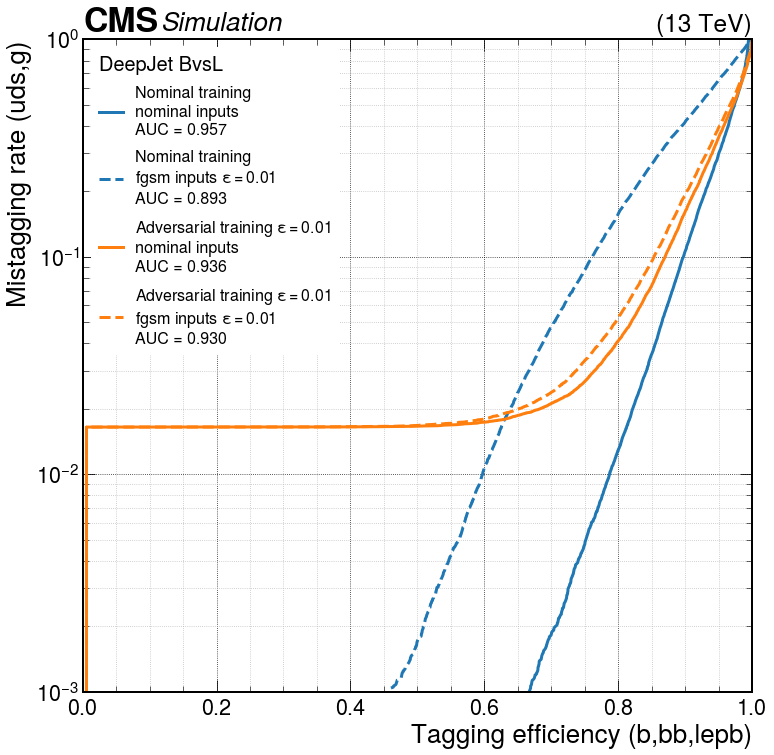

In [49]:
# BvsL
fig,ax = plt.subplots(figsize=[12,12])
ax.set_xlim(left=0.,right=1)
ax.set_yscale('log')
ax.set_ylim(bottom=1e-3)
ax.set_ylim(top=1)

tag_name = ' (b,bb,lepb)'
mistag_name = ' (uds,g)'

ax.set_ylabel('Mistagging rate'+mistag_name)
ax.set_xlabel('Tagging efficiency'+tag_name)
ax.grid(which='minor', alpha=0.85)
ax.grid(which='major', alpha=0.95, color='black')

legtitle = 'BvsL'
legloc = 'upper left'
for model in models:
    for attack_index in range(len(attacks)):
        tpr = model_BvsL_ROC[model][attack_index][0]
        fpr = model_BvsL_ROC[model][attack_index][1]
        auc = model_BvsL_ROC[model][attack_index][2]
        legend_text = model_labels[model] + '\n' + attack_labels[attacks[attack_index]] + '\n' + 'AUC = ' + f'{auc:.3f}'
        ax.plot(tpr, fpr, linestyle=attack_linestyles[attacks[attack_index]], color=model_colors[model],
                linewidth=3.0, label=legend_text)
leg = ax.legend(title='DeepJet '+legtitle, loc=legloc, fontsize=16, title_fontsize=20,
                labelspacing=0.7, frameon=True, framealpha=1, facecolor='white')
if 'right' in legloc:
    aligned = 'right'
else:
    aligned = 'left'
leg._legend_box.align = aligned
leg.get_frame().set_linewidth(0.0)
hep.cms.label(rlabel='(13 TeV)')
fig.savefig('roc_plots/' + legtitle + '_ROC.pdf', bbox_inches='tight')

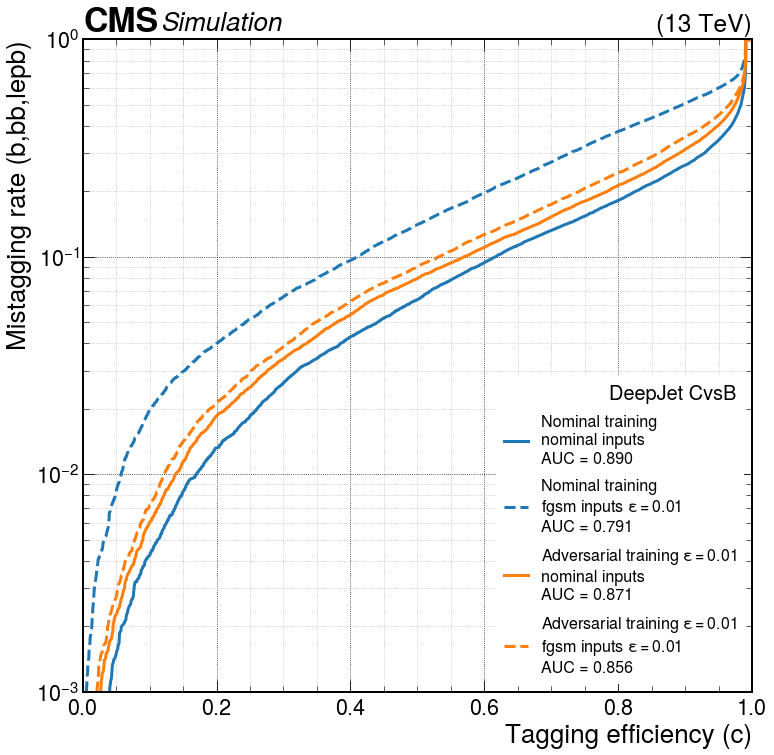

In [50]:
# CvsB
fig,ax = plt.subplots(figsize=[12,12])
ax.set_xlim(left=0.,right=1)
ax.set_yscale('log')
ax.set_ylim(bottom=1e-3)
ax.set_ylim(top=1)

tag_name = ' (c)'
mistag_name = ' (b,bb,lepb)'

ax.set_ylabel('Mistagging rate'+mistag_name)
ax.set_xlabel('Tagging efficiency'+tag_name)
ax.grid(which='minor', alpha=0.85)
ax.grid(which='major', alpha=0.95, color='black')

legtitle = 'CvsB'
legloc = 'lower right'
for model in models:
    for attack_index in range(len(attacks)):
        tpr = model_CvsB_ROC[model][attack_index][0]
        fpr = model_CvsB_ROC[model][attack_index][1]
        auc = model_CvsB_ROC[model][attack_index][2]
        legend_text = model_labels[model] + '\n' + attack_labels[attacks[attack_index]] + '\n' + 'AUC = ' + f'{auc:.3f}'
        ax.plot(tpr, fpr, linestyle=attack_linestyles[attacks[attack_index]], color=model_colors[model],
                linewidth=3.0, label=legend_text)
leg = ax.legend(title='DeepJet '+legtitle, loc=legloc, fontsize=16, title_fontsize=20,
                labelspacing=0.7, frameon=True, framealpha=1, facecolor='white')
if 'right' in legloc:
    aligned = 'right'
else:
    aligned = 'left'
leg._legend_box.align = aligned
leg.get_frame().set_linewidth(0.0)
hep.cms.label(rlabel='(13 TeV)')
fig.savefig('roc_plots/' + legtitle + '_ROC.pdf', bbox_inches='tight')

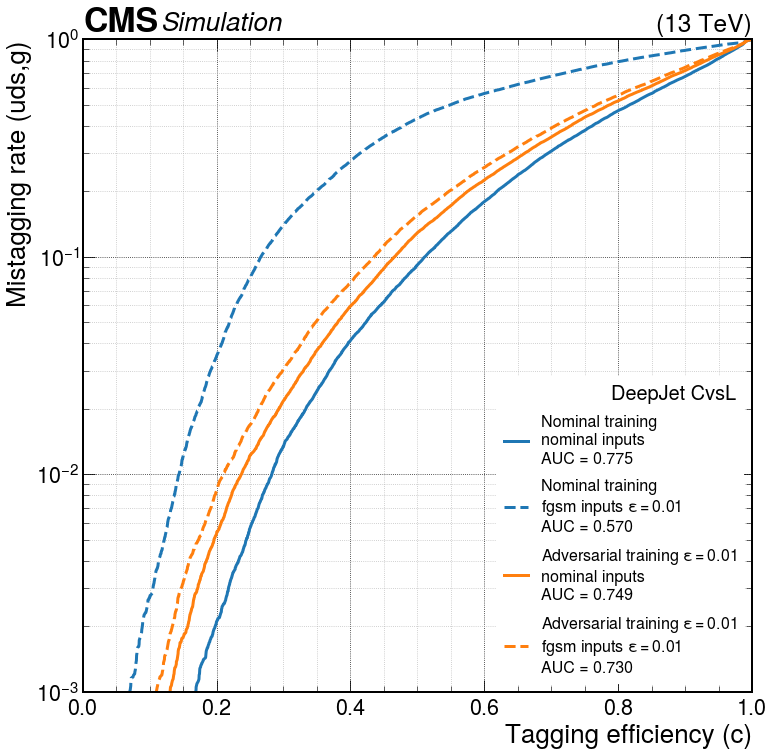

In [51]:
# CvsL
fig,ax = plt.subplots(figsize=[12,12])
ax.set_xlim(left=0.,right=1)
ax.set_yscale('log')
ax.set_ylim(bottom=1e-3)
ax.set_ylim(top=1)

tag_name = ' (c)'
mistag_name = ' (uds,g)'

ax.set_ylabel('Mistagging rate'+mistag_name)
ax.set_xlabel('Tagging efficiency'+tag_name)
ax.grid(which='minor', alpha=0.85)
ax.grid(which='major', alpha=0.95, color='black')

legtitle = 'CvsL'
legloc = 'lower right'
for model in models:
    for attack_index in range(len(attacks)):
        tpr = model_CvsL_ROC[model][attack_index][0]
        fpr = model_CvsL_ROC[model][attack_index][1]
        auc = model_CvsL_ROC[model][attack_index][2]
        legend_text = model_labels[model] + '\n' + attack_labels[attacks[attack_index]] + '\n' + 'AUC = ' + f'{auc:.3f}'
        ax.plot(tpr, fpr, linestyle=attack_linestyles[attacks[attack_index]], color=model_colors[model],
                linewidth=3.0, label=legend_text)
leg = ax.legend(title='DeepJet '+legtitle, loc=legloc, fontsize=16, title_fontsize=20,
                labelspacing=0.7, frameon=True, framealpha=1, facecolor='white')
if 'right' in legloc:
    aligned = 'right'
else:
    aligned = 'left'
leg._legend_box.align = aligned
leg.get_frame().set_linewidth(0.0)
hep.cms.label(rlabel='(13 TeV)')
fig.savefig('roc_plots/' + legtitle + '_ROC.pdf', bbox_inches='tight')

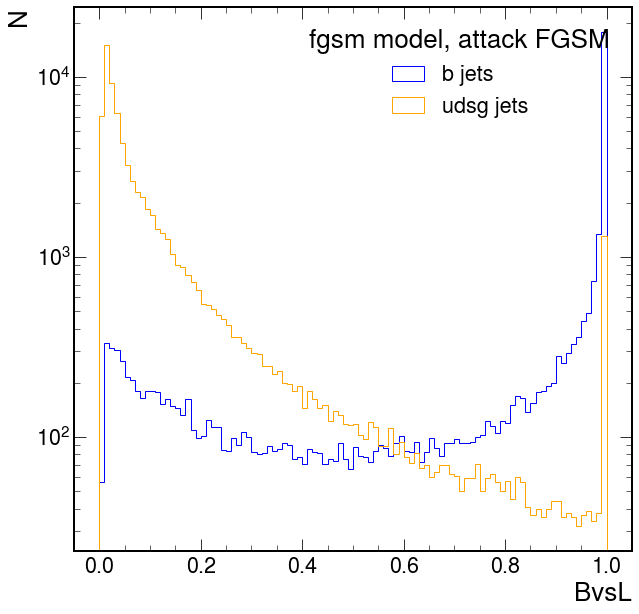

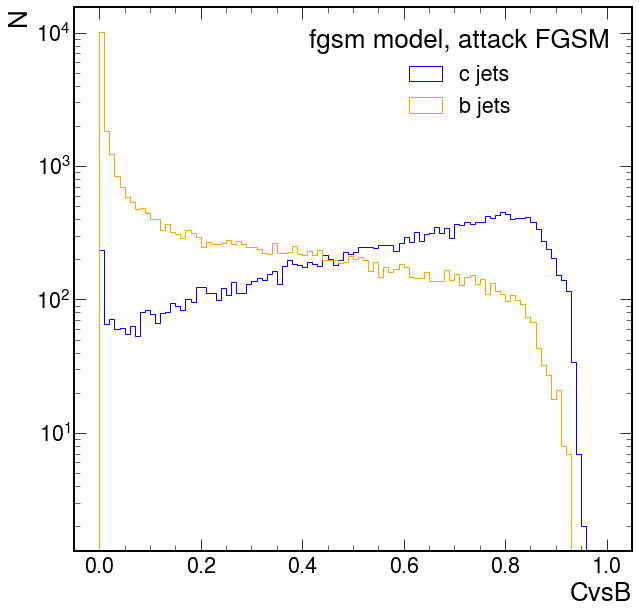

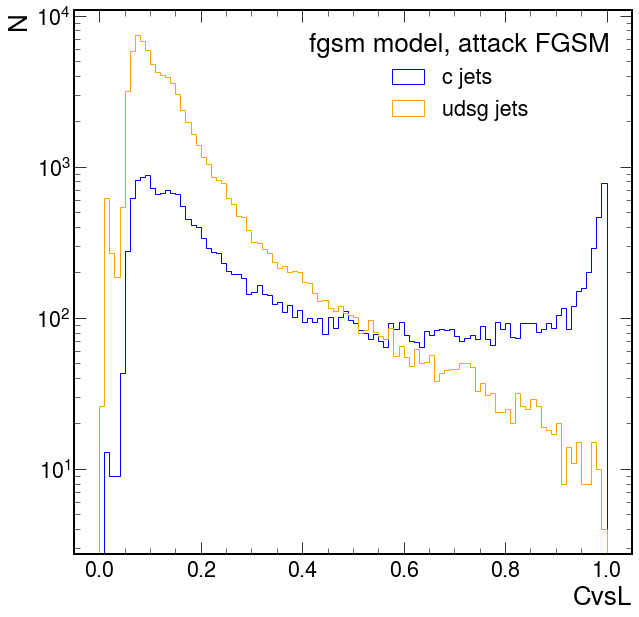

In [69]:
model='fgsm'
attack='FGSM'

attack_index=attacks.index(attack)

b_targets = np.sum(model_targets[model][attack_index][:3,:],axis=0)
c_targets = model_targets[model][attack_index][3,:]
l_targets = np.sum(model_targets[model][attack_index][4:,:],axis=0)

BvsL = model_BvsL[model][attack_index]
CvsB = model_CvsB[model][attack_index]
CvsL = model_CvsL[model][attack_index]

plt.figure()
plt.hist(BvsL[b_targets==1], bins=100, range=(0,1), histtype='step', color='blue', label='b jets')
plt.hist(BvsL[l_targets==1], bins=100, range=(0,1), histtype='step', color='orange', label='udsg jets')
plt.legend(title='{} model, attack {}'.format(model,attack))
plt.yscale('log')
plt.ylabel('N')
plt.xlabel('BvsL')
plt.show()

plt.figure()
plt.hist(CvsB[c_targets==1], bins=100, range=(0,1), histtype='step', color='blue', label='c jets')
plt.hist(CvsB[b_targets==1], bins=100, range=(0,1), histtype='step', color='orange', label='b jets')
plt.legend(title='{} model, attack {}'.format(model,attack))
plt.yscale('log')
plt.ylabel('N')
plt.xlabel('CvsB')
plt.show()

plt.figure()
plt.hist(CvsL[c_targets==1], bins=100, range=(0,1), histtype='step', color='blue', label='c jets')
plt.hist(CvsL[l_targets==1], bins=100, range=(0,1), histtype='step', color='orange', label='udsg jets')
plt.legend(title='{} model, attack {}'.format(model,attack))
plt.yscale('log')
plt.ylabel('N')
plt.xlabel('CvsL')
plt.show()